In [71]:
import numpy as np
import copy 
import time
import random
import math

In [72]:
def str_arr(arr):
    strng = ""
    for obj in arr: 
        if type(obj) is type(""):
            strng += obj + " "   
        else:
            strng += "%.5f" % obj + " "
    return strng

In [488]:
def matrix_approximation(steps, nodes, edges):
    
    # In edge weights.
    N = np.array([edges[n][0][1] for n in nodes], dtype=np.float32)
    S = np.array([1 for n in nodes], dtype=np.float32)
    
    # Adjacency Matrix
    M = []
    for n in nodes:
        column = [0 for _ in range(len(nodes))]
        for e in edges[n]:
            if e[0] != n:
                column[nodes.index(e[0])] = e[1]
        M.append(column)
    M = np.transpose(np.array(M, dtype=np.float32))
    
    print (N)
    print (S)
    print (M)
    
   
    for step in range(steps):        
        # Attribution calculation.
        A = np.multiply(S, N)
        T = np.matmul(M, S)
        for _ in range(100):
            A += np.multiply(T, N)
            T = np.matmul(M, T)
        A = A / np.linalg.norm(A, 1)
        
        E = A * 50 * len(nodes)
        S = S + E
        
    
    return list(A)


nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
         'b': list(zip(['b', 'a'], [0.9, 0.1])),
         'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
         'd': list(zip(['d', 'a', 'b', 'c'], [0.5, 0.2, 0.1, 0.2])),
         'e': list(zip(['e'], [1.0])),
         'f': list(zip(['f'], [1.0])),
         'g': list(zip(['g'], [1.0])),
         'h': list(zip(['h'], [1.0])),
         'i': list(zip(['i'], [1.0])),
         'j': list(zip(['j'], [1.0]))
}
blocks = 10000
print ('Matrix Approximate Attributions:', str_arr(matrix_approximation(blocks, nodes, edges)))


[0.6 0.9 0.4 0.5 1.  1.  1.  1.  1.  1. ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.  0.1 0.3 0.2 0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.2 0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.3 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
Matrix Approximate Attributions: 0.10111 0.21765 0.02635 0.05489 0.10000 0.10000 0.10000 0.10000 0.10000 0.10000 


In [565]:
import copy
class Bittensor:
    
    def __init__(self): 
        
        self.edges = {} # id --> edges.
        self.emit_height = {} # id --> last emit block.
        self.block_height = 0 # chain height.
        
        self.stake = {} # id --> stake
        self.next_stake = {}
        self.total_stake = 0
        self.next_total_stake = 0
        
        
    def subscribe(self, this_identity):
        self.next_total_stake += 1        
        self.next_stake[this_identity] = 1
        
        self.edges[this_identity] = [(this_identity, 1.0)]
        self.emit_height[this_identity] = self.block_height
        
    def inc_height(self):
        self.stake = copy.deepcopy(self.next_stake)
        self.total_stake = self.next_total_stake
        self.block_height += 1
        
    def emit(self, this_identity, edges):
        assert(edges[0][0] == this_identity)
        assert(abs(sum([w for i, w in edges]) - 1.0) < 0.001 )
                
        this_emission = self._get_emission(this_identity)
        self._do_emit(this_identity, this_emission)
               
        self.edges[this_identity] = edges
        self.emit_height[this_identity] = self.block_height
        

    # Bitcoin emission approx.
    def _get_emission(self, this_identity):

        
        EMIT_RATE = 50              
        delta_blocks = self.block_height - self.emit_height[this_identity]    
        
        # NOTE(const): The reinforcement term governs the effect of stake or throughput on the output. 
        stake_reinforcement = (self.stake[this_identity] / self.total_stake)
        
        this_emission = EMIT_RATE * delta_blocks * stake_reinforcement
        return this_emission + 0.01
               
    def _do_emit(self, this_identity, this_emission):
               
        # Recurse the emmision through the tree.
        emission_queue = [(this_identity, this_emission)]
        while len(emission_queue) > 0:
            
            # Next.
            current_identity, current_emission = emission_queue.pop()
            current_inedge = self.edges[current_identity][0][1]
                        
            self.next_stake[current_identity] += (current_emission * current_inedge) 
            self.next_total_stake += (current_emission * current_inedge)
            
            # Recurse.
            for next_identity, next_weight in self.edges[current_identity][1:]:
                next_emission = current_emission * next_weight                
                if next_emission > 0.001:
                    emission_queue.append((next_identity, current_emission * next_weight)) 
                                   
        
    def __str__(self):
        strng = "" 
        strng += "S: " + str_arr([self.stake[identity] for identity in self.stake.keys()]) + "\n" 
        return strng

[0.6 1.  0.4 0.5 0.5 0.5 1.  1.  1.  1. ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.  0.  0.3 0.2 0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.2 0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.3 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
Matrix Approximate Attributions: 0.04884 0.30159 0.01609 0.03348 0.10000 0.10000 0.10000 0.10000 0.10000 0.10000 
Trial Attributions: 0.06314 0.26417 0.02174 0.04411 0.10109 0.10109 0.10117 0.10117 0.10117 0.10117 


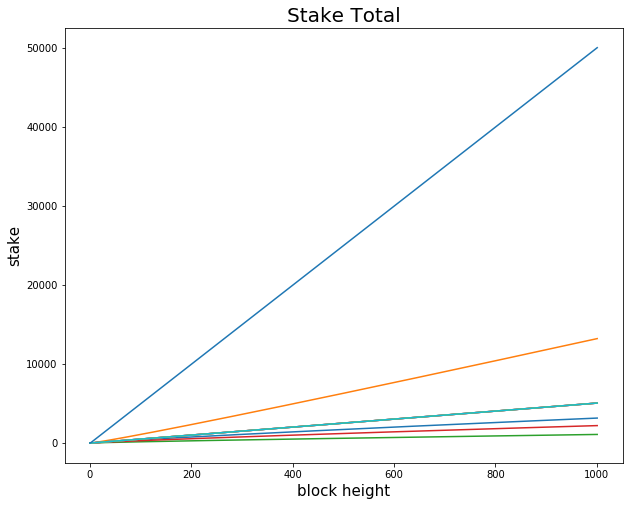

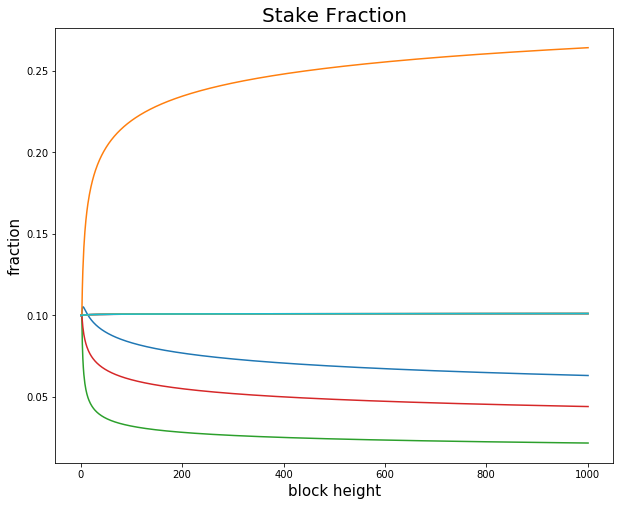

In [566]:

nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
         'b': list(zip(['b'], [1.0])),
         'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
         'd': list(zip(['d', 'a', 'b', 'c'], [0.5, 0.2, 0.1, 0.2])),
         'e': list(zip(['e', 'f'], [0.5, 0.5])),
         'f': list(zip(['f', 'e'], [0.5, 0.5])),
         'g': list(zip(['g'], [1.0])),
         'h': list(zip(['h'], [1.0])),
         'i': list(zip(['i'], [1.0])),
         'j': list(zip(['j'], [1.0]))
}

blocks = 1000

# [trial] --> {id} --> ([block num], [stake])
data = []

trials = 1
for j in range(trials):
    
    first = {}
    for n in nodes:
        first[n] = ([0],[1])
    first['total'] = ([0],[len(nodes)])    
    data.append(first)

    b = Bittensor()
    for k in nodes:
        b.subscribe(k)
    b.inc_height()
        
    for k in nodes:
        b.emit(k, edges[k])
    b.inc_height()
    
    for i in range(blocks):        
        for k in nodes:
            b.emit(k, edges[k])
            data[j][k][1].append(b.stake[k])
            data[j][k][0].append(b.block_height)
        data[j]['total'][1].append(b.total_stake)
        data[j]['total'][0].append(b.block_height)
        b.inc_height()

    

import matplotlib.pyplot as plt
for trial in data:
    
    # plot total stake.
    plt.figure(figsize=(10,8))
    plt.title('Stake Total', fontsize=20)
    plt.xlabel('block height', fontsize=15)
    plt.ylabel('stake', fontsize=15)
    for k in nodes:
        plt.plot(trial[k][0], trial[k][1])      
    plt.plot(trial['total'][0], trial['total'][1])
    
    # plot stake fraction.
    plt.figure(figsize=(10,8))
    plt.title('Stake Fraction', fontsize=20)
    plt.xlabel('block height', fontsize=15)
    plt.ylabel('fraction', fontsize=15)
    for k in nodes:
        plt.plot(trial[k][0], [a/b for a,b in list(zip(trial[k][1], trial['total'][1]))])
        
    print ('Matrix Approximate Attributions:', str_arr(matrix_approximation(blocks, nodes, edges)))
    print ('Trial Attributions:', str_arr([trial[k][1][-1]/trial['total'][1][-1] for k in nodes]))
    
    break

    